### Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO

Библиотеки: [Python, Tensorflow]

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import os
import sys
import skimage.io as io
import numpy as np

import tensorflow as tf
import random
import imageio

import matplotlib.pyplot as plt

%matplotlib inline

from skimage.transform import resize
from tensorflow.keras import layers

In [3]:
tf.__version__

'2.9.2'

Загрузка датасета COCO и COCO API

In [4]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    # Архив с анотациями (разметкой)
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    # Библиотека для работы с натациями датасета COCO
    !cd data && git clone https://github.com/cocodataset/cocoapi
    # Собираем и подготавливаем библиотеку к работе
    !cd data/cocoapi/PythonAPI && make

--2022-12-06 15:10:24--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.44.185, 52.217.204.33, 52.217.1.188, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.44.185|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  7.96MB/s    in 27m 12s 

2022-12-06 15:37:36 (11.3 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-12-06 15:37:36--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.133.129, 52.216.61.1, 52.217.203.121, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.133.129|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 

Подготовка COCO API

In [5]:
# Импортируем библиотеку для чтения нотации и работы с ней
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

Универсальный класс Dataset для сегментации

In [6]:
# Подготавливаем pipeline данных для сегментации
class Dataset():
    
    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):
        

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)
            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class 

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images) 
        dataset = dataset.repeat(epochs) 
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset 

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset


Класс для сегментационного датасета COCO

In [11]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)


    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined 

In [12]:
# создаём train и валидационный датасеты
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


In [13]:
# Уменьшение количества изображений в датасете, чтобы модель обучилась за адекватное время

COCO_dataset_train.cat_ids=COCO_dataset_train.cat_ids[:700]
COCO_dataset_train.img_list=COCO_dataset_train.img_list[:700]

COCO_dataset_val.cat_ids=COCO_dataset_val.cat_ids[:100]
COCO_dataset_val.img_list=COCO_dataset_val.img_list[:100]

In [14]:
len(COCO_dataset_train.img_list), len(COCO_dataset_train.cat_ids)

(700, 1)

In [15]:
len(COCO_dataset_val.img_list), len(COCO_dataset_val.cat_ids)

(100, 1)

In [16]:
NUM_EPOCHS = 5
BATCH_SIZE = 8
inp_size = 256

In [17]:
# из COCO датасетов получаем датасеты для tensorflow

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,inp_size=inp_size)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=inp_size)

Визуализация датасета

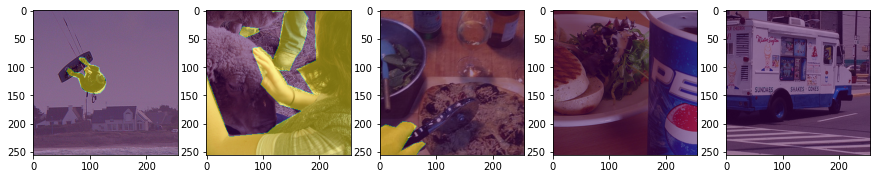

In [18]:
img, mask = next(iter(val_ds.take(1)))

fig  = plt.figure(figsize=(15,6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    ax.imshow(img[i])
    ax.imshow(mask[...,0][i],alpha=0.5)
plt.show()

Создание модели U-Net

In [19]:
def build_model():
    x = tf.keras.layers.Input((inp_size, inp_size, 3)) 
    
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

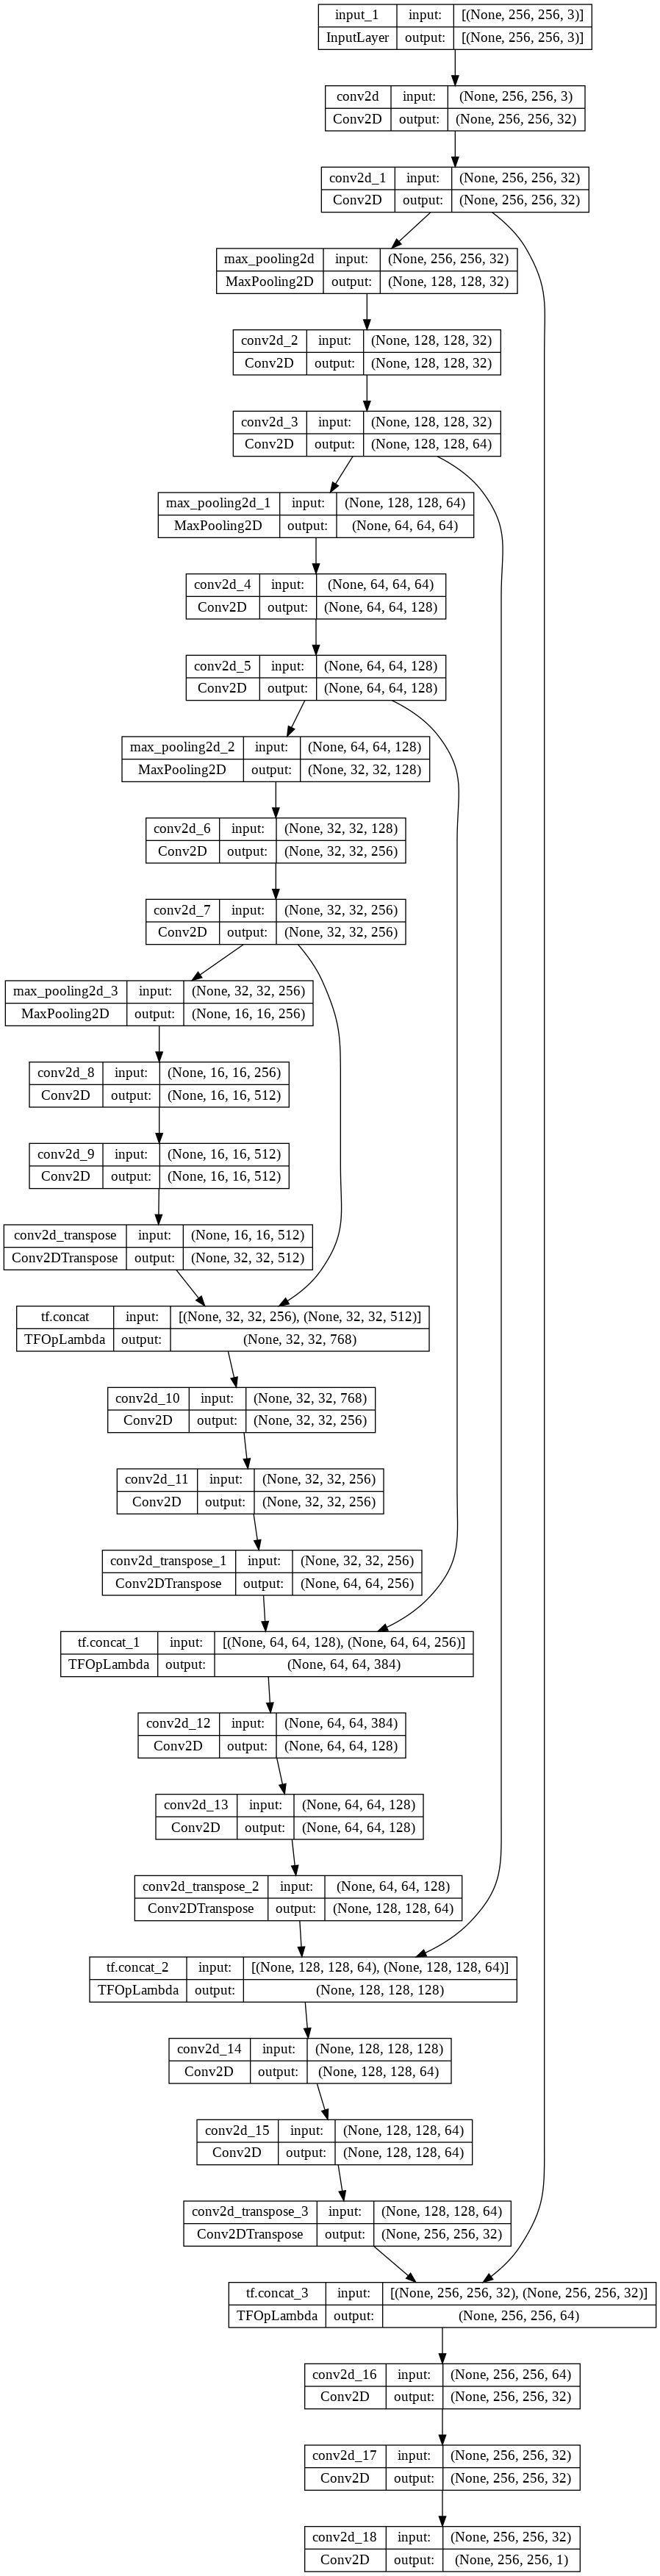

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

Обучение модели

In [21]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [23]:
NUM_EPOCHS = 10
BATCH_SIZE = 16
# inp_size = 256

hist = model.fit(train_ds,
                 batch_size=BATCH_SIZE, 
                 validation_data=val_ds,
                 epochs=NUM_EPOCHS)
                #  callbacks=[checkpoint_callback])

Epoch 1/10
437/437 [==============================] - 135s 308ms/step - loss: 0.4868 - accuracy: 0.7857 - val_loss: 0.5057 - val_accuracy: 0.7591
Epoch 2/10
437/437 [==============================] - 132s 302ms/step - loss: 0.4828 - accuracy: 0.7799 - val_loss: 0.5177 - val_accuracy: 0.7591
Epoch 3/10
437/437 [==============================] - 131s 301ms/step - loss: 0.4782 - accuracy: 0.7860 - val_loss: 0.5034 - val_accuracy: 0.7591
Epoch 4/10
437/437 [==============================] - 131s 300ms/step - loss: 0.4668 - accuracy: 0.7847 - val_loss: 0.5011 - val_accuracy: 0.7591
Epoch 5/10
437/437 [==============================] - 132s 301ms/step - loss: 0.4499 - accuracy: 0.7910 - val_loss: 0.4814 - val_accuracy: 0.7700
Epoch 6/10
437/437 [==============================] - 131s 299ms/step - loss: 0.4395 - accuracy: 0.7887 - val_loss: 0.4752 - val_accuracy: 0.7548
Epoch 7/10
437/437 [==============================] - 130s 298ms/step - loss: 0.4117 - accuracy: 0.7976 - val_loss: 0.4837 -

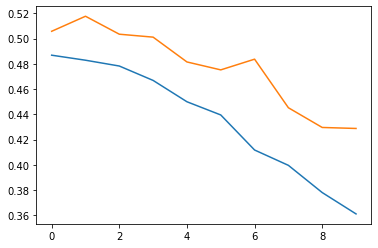

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

Оценка качества

In [26]:
%%time

model.evaluate(val_ds)

12/12 [==============================] - 2s 159ms/step - loss: 0.4288 - accuracy: 0.7810
CPU times: user 2.26 s, sys: 72.9 ms, total: 2.33 s
Wall time: 2.69 s


[0.42876848578453064, 0.7809761166572571]

In [27]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(8, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(8, None, None, None), dtype=tf.float32, name=None))>

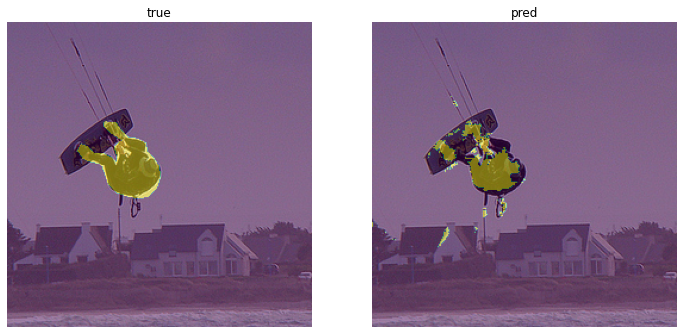

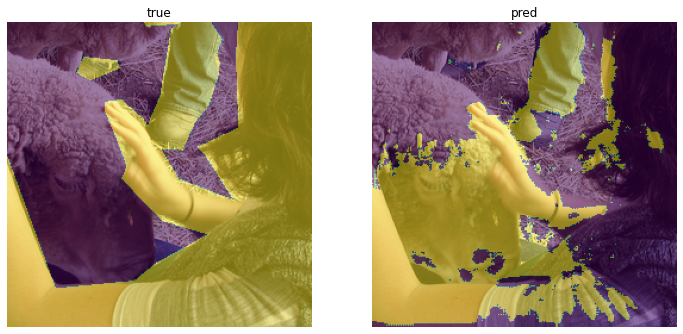

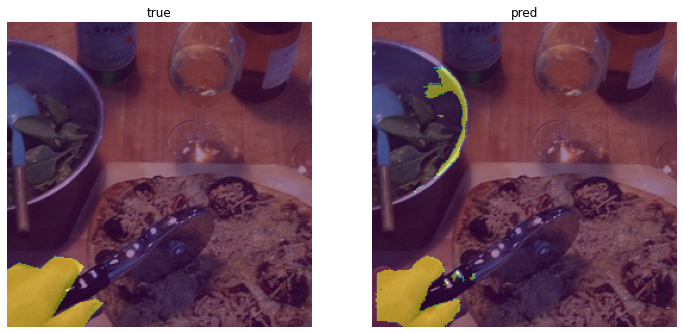

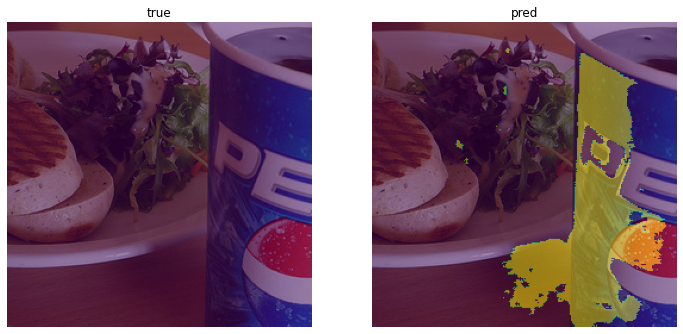

In [28]:
PERCEPTION = 0.5

train_x, train_y = next(iter(val_ds))

pred_prob = model(train_x[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('true')
    plt.imshow(train_x[i])
    plt.imshow(train_y[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('pred')
    plt.imshow(train_x[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')